# 子词嵌入
在英语中，“helps”“helped”和“helping”等单词都是同⼀个词“help”的变形形式。“dog”和“dogs”之
间的关系与“cat”和“cats”之间的关系相同，“boy”和“boyfriend”之间的关系与“girl”和“girlfriend”
之间的关系相同。在法语和西班⽛语等其他语⾔中，许多动词有40多种变形形式，⽽在芬兰语中，名词最多
可能有15种变形。在语⾔学中，形态学研究单词形成和词汇关系。但是，word2vec和GloVe都没有对词的内
部结构进⾏探讨。

## fastText模型
回想⼀下词在word2vec中是如何表⽰的。在跳元模型和连续词袋模型中，同⼀词的不同变形形式直接由不同
的向量表⽰，不需要共享参数。为了使⽤形态信息，fastText模型提出了⼀种⼦词嵌⼊⽅法，其中⼦词是⼀个
字符n-gram (Bojanowski et al., 2017)。fastText可以被认为是⼦词级跳元模型，⽽⾮学习词级向量表⽰，其
中每个中⼼词由其⼦词级向量之和表⽰。

让我们来说明如何以单词“where”为例获得fastText中每个中⼼词的⼦词。⾸先，在词的开头和末尾添加特
殊字符“<”和“>”，以将前缀和后缀与其他⼦词区分开来。然后，从词中提取字符n-gram。例如，值n = 3时，
我们将获得⻓度为3的所有⼦词：“<wh”“whe”“her”“ere”“re>”和特殊⼦词“<where>”。

在fastText中，对于任意词w，⽤Gw表⽰其⻓度在3和6之间的所有⼦词与其特殊⼦词的并集。词表是所有词的
⼦词的集合。假设zg是词典中的⼦词g的向量，则跳元模型中作为中⼼词的词w的向量vw是其⼦词向量的和：

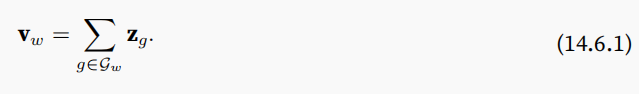

fastText的其余部分与跳元模型相同。与跳元模型相⽐，fastText的词量更⼤，模型参数也更多。此外，为了
计算⼀个词的表⽰，它的所有⼦词向量都必须求和，这导致了更⾼的计算复杂度。然⽽，由于具有相似结构
的词之间共享来⾃⼦词的参数，罕⻅词甚⾄词表外的词在fastText中可能获得更好的向量表⽰。

## 字节对编码（Byte Pair Encoding）
在fastText中，所有提取的⼦词都必须是指定的⻓度，例如3到6，因此词表⼤⼩不能预定义。为了在固定⼤⼩
的词表中允许可变⻓度的⼦词，我们可以应⽤⼀种称为字节对编码（Byte Pair Encoding，BPE）的压缩算法
来提取⼦词 (Sennrich et al., 2015)。

字节对编码执⾏训练数据集的统计分析，以发现单词内的公共符号，诸如任意⻓度的连续字符。从⻓度为1的
符号开始，字节对编码迭代地合并最频繁的连续符号对以产⽣新的更⻓的符号。请注意，为提⾼效率，不考
虑跨越单词边界的对。最后，我们可以使⽤像⼦词这样的符号来切分单词。字节对编码及其变体已经⽤于诸
如GPT-2 (Radford et al., 2019)和RoBERTa (Liu et al., 2019)等⾃然语⾔处理预训练模型中的输⼊表⽰。在下
⾯，我们将说明字节对编码是如何⼯作的。

⾸先，我们将符号词表初始化为所有英⽂⼩写字符、特殊的词尾符号'_'和特殊的未知符号'[UNK]'。

In [2]:
import collections
symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
'_', '[UNK]']

因为我们不考虑跨越词边界的符号对，所以我们只需要⼀个字典raw_token_freqs将词映射到数据集中的频
率（出现次数）。注意，特殊符号'_'被附加到每个词的尾部，以便我们可以容易地从输出符号序列（例如，“a_all
er_man”）恢复单词序列（例如，“a_all er_man”）。由于我们仅从单个字符和特殊符号的词开始合并处理，
所以在每个词（词典token_freqs的键）内的每对连续字符之间插⼊空格。换句话说，空格是词中符号之间的
分隔符。

In [4]:
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

我们定义以下get_max_freq_pair函数，其返回词内最频繁的连续符号对，其中词来⾃输⼊词典token_freqs的
键。

In [5]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # “pairs”的键是两个连续符号的元组
            pairs[symbols[i], symbols[i + 1]] += freq
    return max(pairs, key=pairs.get) # 具有最⼤值的“pairs”键

作为基于连续符号频率的贪⼼⽅法，字节对编码将使⽤以下merge_symbols函数来合并最频繁的连续符号对
以产⽣新符号。

In [6]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair),
                                  ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

现在，我们对词典token_freqs的键迭代地执⾏字节对编码算法。在第⼀次迭代中，最频繁的连续符号
对是't'和'a'，因此字节对编码将它们合并以产⽣新符号'ta'。在第⼆次迭代中，字节对编码继续合
并'ta'和'l'以产⽣另⼀个新符号'tal'。

In [7]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'合并# {i+1}:',max_freq_pair)

合并# 1: ('t', 'a')
合并# 2: ('ta', 'l')
合并# 3: ('tal', 'l')
合并# 4: ('f', 'a')
合并# 5: ('fa', 's')
合并# 6: ('fas', 't')
合并# 7: ('e', 'r')
合并# 8: ('er', '_')
合并# 9: ('tall', '_')
合并# 10: ('fast', '_')


在字节对编码的10次迭代之后，我们可以看到列表symbols现在⼜包含10个从其他符号迭代合并⽽来的符号。

In [8]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


对于在词典raw_token_freqs的键中指定的同⼀数据集，作为字节对编码算法的结果，数据集中的每个词现
在被⼦词“fast_”“fast”“er_”“tall_”和“tall”分割。例如，单词“fast er_”和“tall er_”分别被分割为
“fast er_”和“tall er_”。

In [9]:
print(list(token_freqs.keys()))

['fast_', 'fast er_', 'tall_', 'tall er_']


请注意，字节对编码的结果取决于正在使⽤的数据集。我们还可以使⽤从⼀个数据集学习的⼦词来切分另⼀
个数据集的单词。作为⼀种贪⼼⽅法，下⾯的segment_BPE函数尝试将单词从输⼊参数symbols分成可能最⻓
的⼦词。

In [10]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # 具有符号中可能最⻓⼦字的词元段
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

使⽤列表symbols中的⼦词（从前⾯提到的数据集学习）来表⽰另⼀个数据集的tokens。

In [11]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_']


## 小结
* fastText模型提出了⼀种⼦词嵌⼊⽅法：基于word2vec中的跳元模型，它将中⼼词表⽰为其⼦词向量之和。
* 字节对编码执⾏训练数据集的统计分析，以发现词内的公共符号。作为⼀种贪⼼⽅法，字节对编码迭代地合并最频繁的连续符号对。
* ⼦词嵌⼊可以提⾼稀有词和词典外词的表⽰质量。